In [4]:
#clone repository until final version of package is released
!git clone https://github.com/oskarfernlund/niteshade.git
%cd 'niteshade/'

#necessary installs
!pip install fpdf
#!pip install niteshade

fatal: destination path 'niteshade' already exists and is not an empty directory.
/Users/alexandrantemourtsidou/Desktop/niteshade/niteshade


# Import Necessary Libraries

In [5]:
#necessary imports
import numpy as np
import torch

from niteshade.attack import AddLabeledPointsAttacker, LabelFlipperAttacker, BrewPoison
from niteshade.defence import FeasibleSetDefender, KNN_Defender, SoftmaxDefender
from niteshade.models import MNISTClassifier, CifarClassifier, BaseModel
from niteshade.postprocessing import PostProcessor
from niteshade.simulation import Simulator, wrap_results
from niteshade.utils import train_test_iris, train_test_MNIST, train_test_cifar
from niteshade.data import DataLoader

import matplotlib.pyplot as plt

# Using the **niteshade** Pipeline to Test Attack and Defense Strategies on an Off The Shelf MNIST Classifier

In [6]:
X_train, y_train, X_test, y_test = train_test_MNIST()

In [7]:
torch.manual_seed(0) #seed for reproducibility

BATCH_SIZE = 128 # --> mini-batches on which model is trained on
NUM_EPISODES = 30 # --> number of times the attacker/defender intervene
lrs = [0, 0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1, 0.5, 1]

#define attacker and defender
label_flips_dict = {1:9, 9:1}
attacker = LabelFlipperAttacker(1, label_flips_dict)
defender = FeasibleSetDefender(X_train, y_train, 2000)

#define model and simulator
baseline_model = MNISTClassifier(lr=0.01)
simulator_regular = Simulator(X_train, y_train, baseline_model, attacker=attacker,
                    defender=None, batch_size=BATCH_SIZE, num_episodes=NUM_EPISODES)

simulator_regular.run()
simulators = {'regular_0.01': simulator_regular}

for lr in lrs:
    model = MNISTClassifier(lr=lr)
    simulator = Simulator(X_train, y_train, model, attacker=attacker,
                defender=defender, batch_size=BATCH_SIZE, num_episodes=NUM_EPISODES)
    simulator.run()
    simulators[f'lr_{lr}'] = simulator
    

postprocessor = PostProcessor(simulators)
metrics = postprocessor.evaluate_simulators_metrics(X_test, y_test)

100%|███████████████████████████████████████████| 13/13 [00:12<00:00,  1.07it/s]


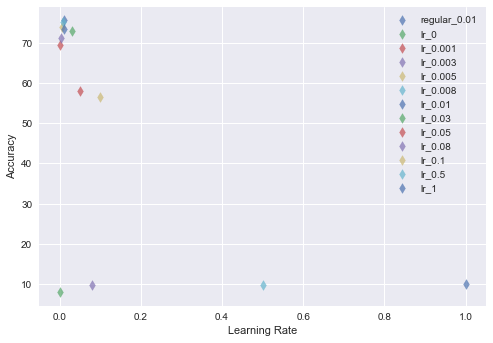

In [8]:
fig, ax = plt.subplots()
for key, value in metrics.items():
    x = float(key.split('_')[-1])
    y = value
    ax.scatter(x, y, label=key, marker='d', alpha=0.7)

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')
plt.legend()
plt.show()